In [1]:
# import pdb; pdb.set_trace()
# import pudb; pudb.set_trace()

# df.style.background_gradient(
#     cmap='coolwarm', 
#     axis=None, 
#     vmin=-1, 
#     vmax=1
# )  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG'

# pd.set_option('precision', 2)

# .plot_bokeh(sizing_mode="scale_height")
# .plot_bokeh(kind='hist', bins=1000, sizing_mode="scale_height", xlim=[0, .1])

# Imports

In [36]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 99)

import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

import datetime as dt
import pickle
import numpy as np
import pandas as pd
import pandas_bokeh
pandas_bokeh.output_file("tmp/bokeh_output.html")
import ray

from data_layer import arrow_dataset, storage_adaptor
from tick_filter import streaming_tick_filter
from tick_sampler import streaming_tick_sampler, daily_stats
from workflows import sampler_task, sampler_flow, read_flow
from workflows.configs import renko_v1, renko_v2
from utilities import date_fu, project_globals as g
from data_layer import storage_adaptor, fsspec_factory, data_access, arrow_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
config = renko_v2.config

prefix_data = '/data/trades'

prefix_meta = f"/bars/{config['meta']['config_id']}/meta"

prefix_df = f"/bars/{config['meta']['config_id']}/df"

In [9]:
data_access.list_sd_data('AEM',prefix=prefix_df, source='remote', show_storage=True)

{'MB': 12.2}

In [11]:
date = '2020-01-02'

df = data_access.fetch_sd_data('GLD', date, prefix_df)

In [12]:
ticks_df = data_access.fetch_sd_data('AU', date, '/data/trades')

In [14]:
bar_date = data_access.fetch_sd_data('AU', date, prefix_meta)

fidx = bar_date['filtered_df']

fidx.index

In [101]:
prefix_df

'/bars/renko_v2/df'

<AxesSubplot:xlabel='sip_dt'>

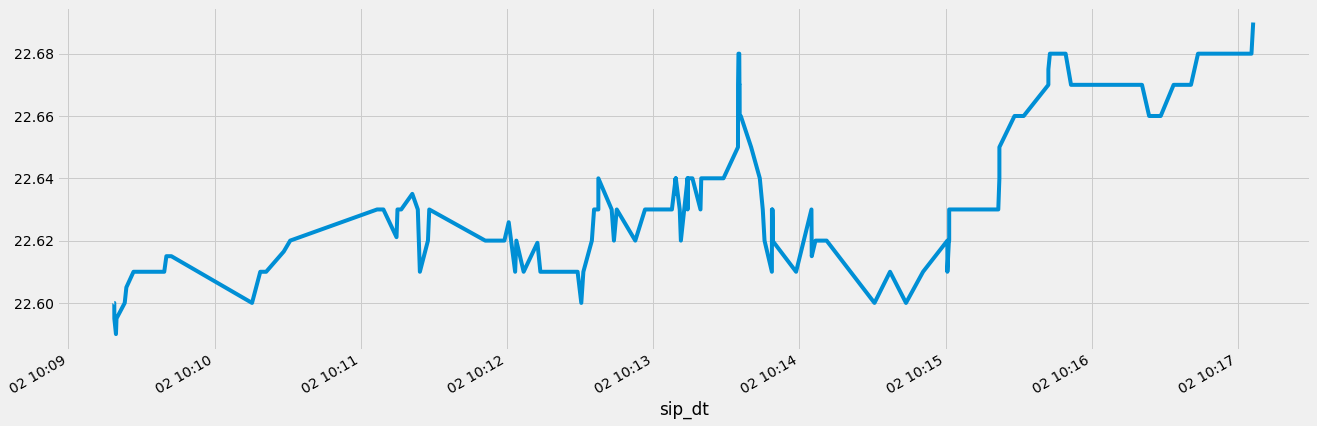

In [93]:
n = 13

open_at = bar_date['bars'][n]['open_at']

close_at = bar_date['bars'][n]['close_at']

bar_ticks = tdf.loc[(tdf.index >= open_at) & (tdf.index <= close_at)]

bar_ticks.price.plot()

In [ ]:
from data_layer import data_access
from sample_features import ticks_to_bar

prefix_df = '/bars/renko_v2/df'
prefix_meta = '/bars/renko_v2/meta'

sym_leaders = data_access.list_sd_data(prefix=prefix_df, source='local')
sym_leaders = ['VTI', 'GLD']
sym_followers = ['AU','SAND']

for sym_follow in sym_followers:
	date_list = data_access.list_sd_data(sym_follow, prefix=prefix_df, source='local')
	# date_list = ['2020-01-02', '2020-01-03']
	for date in date_list:
		bars_df = data_access.fetch_sd_data(sym_follow, date, prefix=prefix_df)

		for sym_leader in sym_leaders:
			# get sym pair ticks
			ticks_df = data_access.fetch_sd_data(sym_leader, date, prefix='/data/trades')
			# get precomputed filter idx
			bar_date = data_access.fetch_sd_data(sym_leader, date, prefix=prefix_meta)
			fidx = bar_date['filtered_df']
			tdf = ticks_df.drop(index=fidx.index)
			tdf = tdf.set_index('sip_dt').tz_localize('UTC').tz_convert('America/New_York')
			# for each bar in sym_follower
			bars = []
			for bar in bars_df.itertuples():
				bar_ticks = tdf.loc[(tdf.index >= bar.open_at) & (tdf.index <= bar.close_at)]
				bdf = ticks_to_bar.ticks_to_bar(price=bar_ticks['price'], volume=bar_ticks['size'], close_at=bar_ticks.index)
				bars.append(bdf)

			data_access.presist_sd_data(pd.DataFrame(bars), sym_leader, date, prefix=f"/sync_bars/{sym_follow}", destination='both')


In [114]:
sym_leaders

['VTI', 'GLD']

In [110]:
pf = f"/sync_bars/{sym_follow}"

In [118]:
data_access.list_sd_data('GLD', prefix=pf, show_storage=False)

523

In [119]:
df = data_access.fetch_sd_data('GLD', '2020-01-02', prefix=pf)

In [127]:
df2 = data_access.fetch_sd_data('GLD', '2020-01-02', prefix=prefix_df)

<AxesSubplot:>

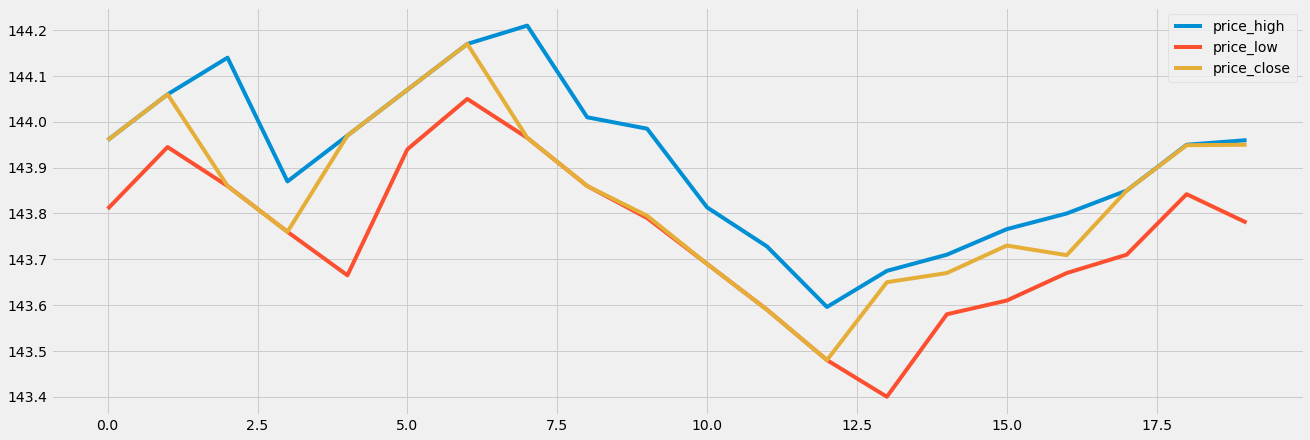

In [128]:
df2[['price_high','price_low','price_close']].plot()

<AxesSubplot:>

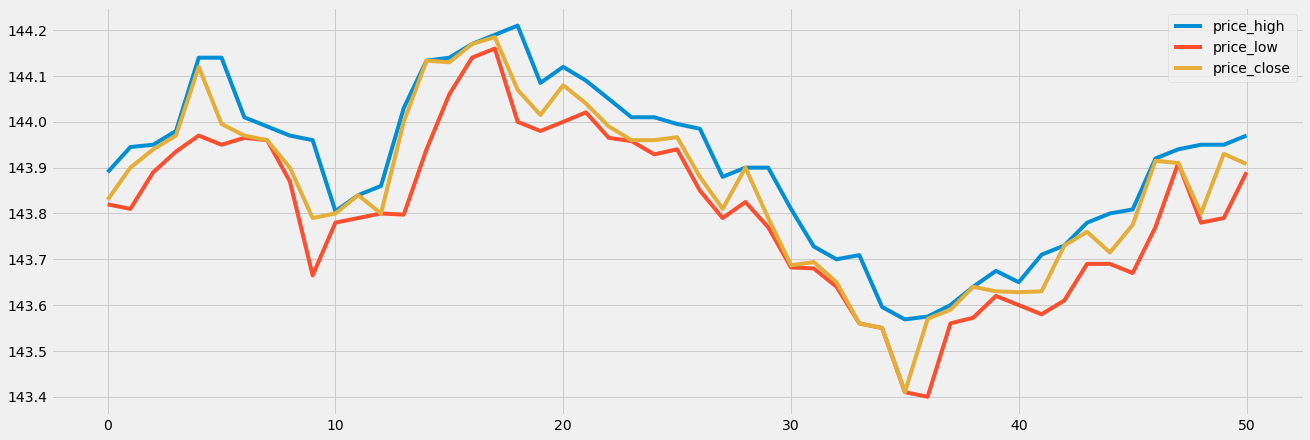

In [125]:
df[['price_high','price_low','price_close']].plot()

# Read flow

In [ ]:
ds = arrow_dataset.get_dataset(prefix_df, fs_type='s3')

df = ds.to_table().to_pandas()

In [ ]:
df.groupby(['symbol','date']).mean().reset_index().groupby('symbol').mean().describe()

In [ ]:
df.groupby(['symbol','date']).count().reset_index().groupby('symbol').mean().describe()

# Tick Sampler 

In [ ]:
ray.init(dashboard_host='0.0.0.0', dashboard_port=1111, ignore_reinit_error=True)

In [ ]:
ray.shutdown()

In [ ]:
bds = sampler_flow.run(config)

2019-01-03


<AxesSubplot:>

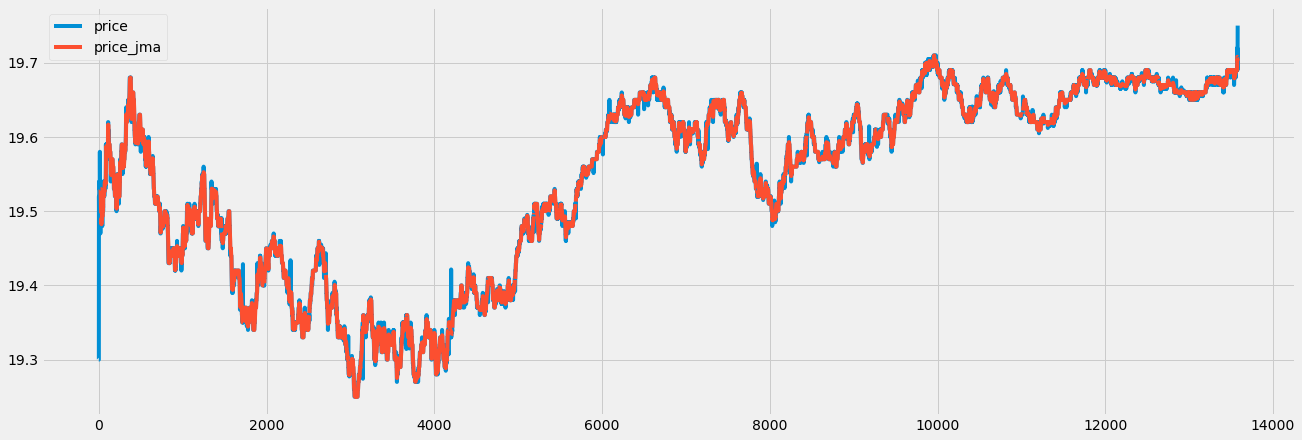

In [20]:
n = 1
print(bds[n]['date'])
# bds[n]['ticks_df'][['price', 'price_jma']].plot_bokeh(sizing_mode="scale_height")
bds[n]['ticks_df'][['price', 'price_jma']].plot()

<AxesSubplot:>

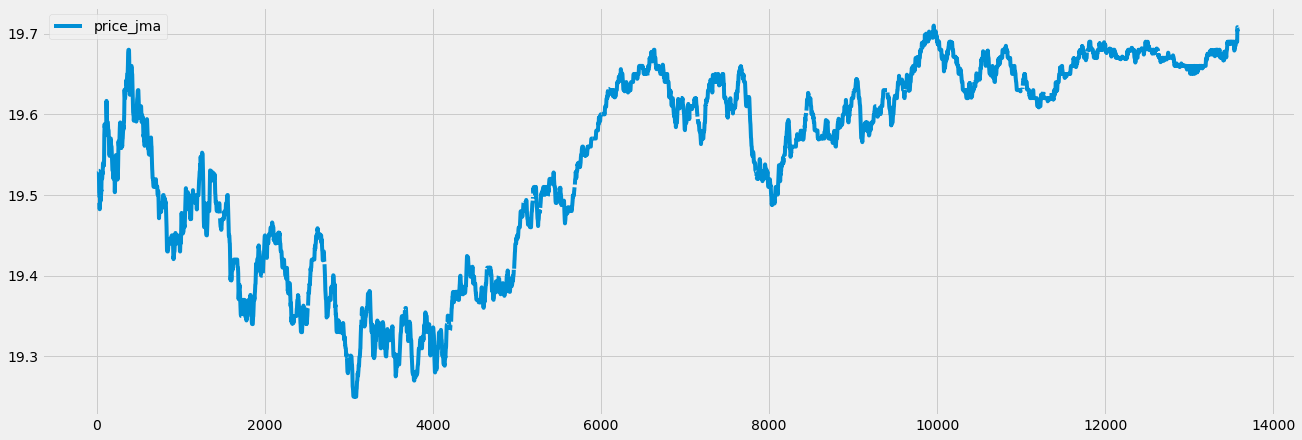

In [21]:
bds[n]['ticks_df'][['price_jma']].plot()

In [22]:
bds[n]['ticks_df'].status.value_counts() / len(bds[n]['ticks_df'])

clean: market-open              0.983136
filtered: irregular condition   0.013771
clean: after-hours              0.001473
filtered: mad_warmup            0.001399
filtered: ts diff               0.000147
filtered: mad_outlier           0.000074
Name: status, dtype: float64

<AxesSubplot:>

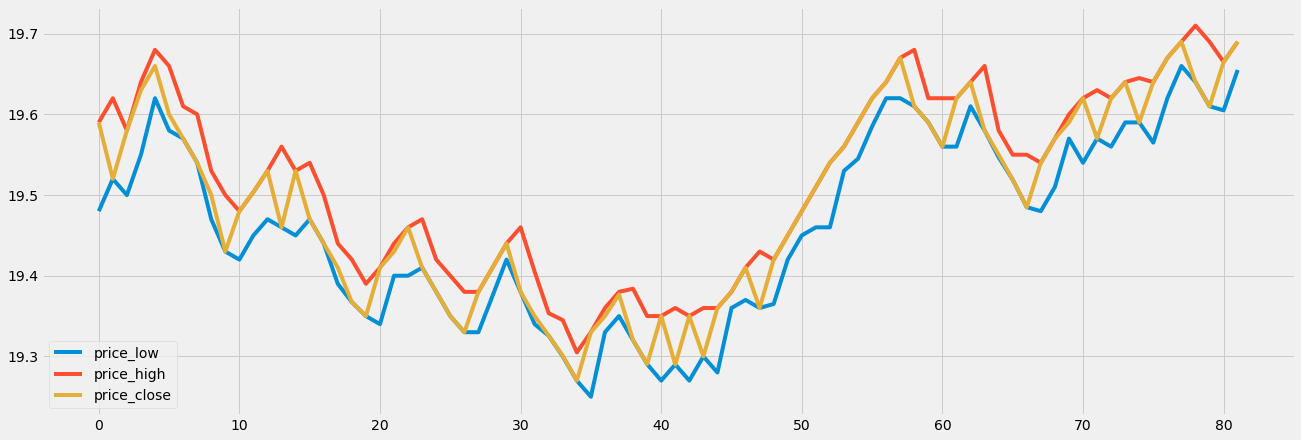

In [23]:
bds[n]['bars_df'][['price_low', 'price_high', 'price_close']].plot()

# Price gap fill

In [ ]:
from sample_features import stacked
# fill daily gaps
stacked_df = stacked.fill_gaps_dates(bar_dates, fill_col='price_vwap')

# stacked_df[['price_high','price_low','price_close', 'price_vwap']].plot_bokeh(sizing_mode="scale_height")

# stacked stats
stats_df = stacked.stacked_df_stats(stacked_df)


In [ ]:
stats_df.describe()